# The Do-Operator and Bayesian Models

The do-operator is a foundational idea in causal methods,
used to express, in precise mathematical language,
what counterfactual interventions would look like.
The do-operator from causal inference has a tight connection to probabilistic modelling.
But what exactly is that connection?

Having myself been previously confused about the link between graphical models,
causal structure, and more,
here's my current understanding of the connection.

## Causal models and Bayesian models, in brief

Let’s start first with a brief overview of the connection between 
causal models and Bayesian models. 
In doing my own study on causality, 
it soon became clear to me that causal models 
can be read off from mathematical equations quite easily. 
For a moment, let's assume we have the following set of equations 
that we presume to describe some data that we observe:


$$b = \delta d + \epsilon e + \sigma_b$$

and 

$$a = \beta b + \gamma c + \sigma_a$$



My convention here is that the English letters represent data, 
while the Greek letters represent parameters of the model.


To make this abstract example a bit more concrete,
let's connect these equations to something in real life,
such as scholastic achievement.
In this highly contrived and fictitious example,
let's say that $a$ is the scholastic achievement of a student 
as measured by the sum total of subject scores
across 11 subjects in the O-level examinations 
administered by the University of Cambridge,
and it is thought to be a function of:

- $b$, the intelligence quotient (IQ) of the student,
- $c$, the cost of a student's tuition fees in thousands of dollars (private vs. public school), and
- $\sigma_a$, the intrinsic variation in student performance as a whole

For the term $b$, we think it is a function of:

- $d$, the crime rate of their neighborhood, 
- $e$, the household income of that student, in thousands of dollars, and
- $\sigma_b$, the intrinsic variation in IQ.

The astute reader will immediately see the controversy in this example.
The causal path we assume here isn't going to be the only plausible model,
and there are many, many variables we're leaving out here.
However, I'd ask that you let your mind suspend the controversy for a moment;
it's always a big brain teaser to try to come up with plausible but fictitious examples.


To read off the causal model from this set of equations, 
everything on the right is causal for the stuff on the left.
By those equations, 
we state that the values of $a$ that we observe 
are caused by values of $b$ and $c$ and their Greek coefficients $\beta$ and $\gamma$
plus some noise $\sigma_a$,
while the values of $b$ that we observe 
are caused by the values of $d$ and $e$ and their Greek coefficients $\delta$ and $\epsilon$
plus some noise $\sigma_b$.


**With Bayesian inference on this model, 
our task here is to estimate the coefficients**, 
$\beta$, $\gamma$, $\delta$, and $\epsilon$. 
More precisely, we are interested in estimating their expected value and uncertainty. 

In order to express the model in such a way that reflects its probabilistic in nature, 
we need some syntax to express the idea that 
because $\delta$, $\epsilon$ and $\sigma_b$ are uncertain 
and are modelled by a probability distribution, 
therefore $b$ is uncertain and has a corresponding probability distribution too. 

At the same time, 
we need an analogous syntax to express that
because $\beta$, $\gamma$, and $\sigma_a$ are uncertain
and are modelled by a probability distribution,
therefore $a$ is also uncertain and has a corresponding probability distribution too. 



Moreover, if we assume that $c$, $d$, $e$ are stochastic 
because they are drawn from a distribution, 
then we have ~~a classic case where everything is unknown and we can’t do anything~~ 
an awesome modelling problem at hand! 🙂 
In any case, for the first equation, 
our expression for the distribution of $b$ 
conditioned on everything on the right would look something like:

$$P(b | \delta, \epsilon, \sigma_b, d, e)$$

And likewise, the distribution of $a$ conditioned on everything on the right would look something like this:

$$P(a | \beta, \gamma, \sigma_a, b, c)$$


Now, in Bayesian inference, 
we usually regard $(b, c, d, e)$ as being fixed (and hence sacred), 
because they are the *data that we have observed.* 
By convention, in many probabilistic modelling problems, 
we’re not really concerned about the data generating processes for $(b, c, d, e)$ 
because they aren’t usually the sample-invariant, 
intrinsic parameter of a system we’re interested in,
unlike the Greek-letter symbols which take on their values
independent of any given measured sample.

## Causal inference vs Bayesian inference, in brief

I’d now like to address “causal inference” vs. “bayesian inference”; I think the use of a contrast is going to be helpful here.

Bayesian inference asks the question, “given the observed data and a presumed model with parameters, what is the expectation and uncertainty in the parameters that could have generated the observed data?”

Causal inference asks the question, “given the observed data, what are plausible structures of the model that could have generated the observed data?”

## Structures: in graphics and in equations

By structures, we’re really asking about the relationships between variables. 
Using the above example again, 
if $a$ is caused by $b$ and $c$, 
then in abstract, we'd write that $a = f(b, c)$. 
We would then draw the following diagram to express the relationship:


In [1]:
%config InlineBackend.figure_format='retina'

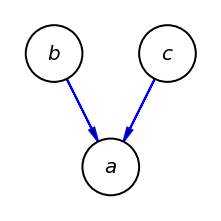

In [2]:
import daft

scale = 2.0
pgm = daft.PGM()
pgm.add_node("a", r"$a$", 1.5, 1)
pgm.add_node("b", r"$b$", 1, 2)
pgm.add_node("c", r"$c$", 2, 2)

a_color = {"ec": "blue"}

pgm.add_edge("b", "a", plot_params=a_color)
pgm.add_edge("c", "a", plot_params=a_color)
pgm.render();

Likewise, since we presume that $b$ is caused by $d$ and $e$, 
then the functional form of the causal relationship will be $b = g(d, e)$. 
We would then draw the following diagram to express the relationship:

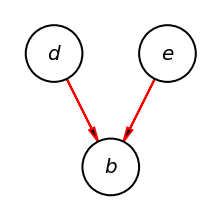

In [3]:
pgm = daft.PGM()
pgm.add_node("b", r"$b$", 1.5, 1)
pgm.add_node("d", r"$d$", 1, 2)
pgm.add_node("e", r"$e$", 2, 2)

b_color = {"ec": "red"}


pgm.add_edge("d", "b", plot_params=b_color)
pgm.add_edge("e", "b", plot_params=b_color)
pgm.render();

And taken together, the full model would look like:

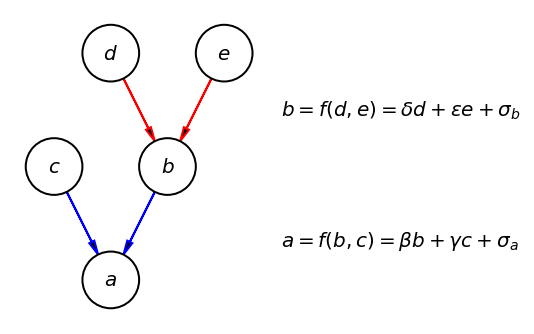

In [4]:
pgm = daft.PGM()
pgm.add_node("a", r"$a$", 1.5, 1)
pgm.add_node("b", r"$b$", 2, 2)
pgm.add_node("c", r"$c$", 1, 2)
pgm.add_node("d", r"$d$", 1.5, 3)
pgm.add_node("e", r"$e$", 2.5, 3)

pgm.add_edge("c", "a", plot_params=a_color)
pgm.add_edge("b", "a", plot_params=a_color)
pgm.add_edge("d", "b", plot_params=b_color)
pgm.add_edge("e", "b", plot_params=b_color)

pgm.add_text(3, 1.25, r"$a = f(b, c) = \beta b + \gamma c + \sigma_a$")
pgm.add_text(3, 2.4, r"$b = f(d, e) = \delta d + \epsilon e + \sigma_b$")

pgm.render();

In economics, the term “structural equation models” 
refers to the system of equations 
that form the econometric model that economists build. 
Usually, those models are linear in nature. 
On occasion, though, additional functional forms might be used 
(sigmoidal, piecewise linear, neural network, etc.), 
if they help model the phenomena at hand. 
Whatever the form of the equation gets encapsulated into $f(v_1, v_2, ..., v_n)$,
where $v_1... v_n$ refer to the variables like $b$ and $c$ above.

Structure, then, can refer to both the graphical structure of the model 
and the particular form of equations. 
As far as I have seen, 
most causal models assume some kind of linear equation between variables, 
though there are exceptions; 
in addition, causal inference, as taught, 
is usually concerned with inferring the *graphical* relationship between variables, 
presuming some linear form underneath. 
Inferring the model structure is what we call "model inference".

*A note for deep learners: this is what model inference actually is: 
inferring the structure of a model. 
More generally, if you think about linguistic convention, 
“X inference” usually refers to the tools and processes used in inferring X. 
Calling model inference the forward pass through the model breaks linguistic convention, 
and hence introduces viscosity in communication with others 
who adopt said linguistic convention!*

## Restating the distinction

At this point, I think it's an appropriate moment to try to re-state clearly
what the relationship between a "causal inference" and a "Bayesian inference" is.
They are **both** concerned with the system of equations that make up our model.
However, in causal inference, 
we are primarily concerned with the relationship between observed variables, 
expressed as math equations.
In Bayesian inference, we are primarily concerned with the parameters of those equations
and their uncertainty.

## The do-operator

Finally, we reach the point where we can touch the do-operator!
This is such a key and crucial idea to causal methods,
as it allows us to do **counterfactual** arguments conditioned on a presumed model.
To illustrate what we mean by the do-operator,
I'm going to rely on code, prose, and equations together.
To start, let's implement the full probabilistic model above in Python code.



In [5]:
import numpy as np 
from scipy.stats import norm
import pandas as pd 


In [6]:
# Equations
beta = 10
gamma = 0.3
delta = -30
epsilon = 0.1
sigma_a_dist = norm(0, 3)
sigma_b_dist = norm(0, 3)


def a_equation(b, c):
    return beta * b + gamma * c + sigma_a_dist.rvs()

def b_equation(d, e):
    return delta * d + epsilon * e + sigma_b_dist.rvs()

To generate the data, we always begin with the nodes
that have no parental nodes.
In more complicated networks, 
we would leverage tools from network science, in this case, the _topological sort_,
to identify the exact order in which we need to simulate observations.
The observed data that we would end up collecting 
for this system looks like the following:

In [7]:
sigma_a_dist.rvs()

-0.3581757669205893

In [8]:
cc = norm(50, 5).rvs(100)
dd = norm(-4, 1).rvs(100)
ee = norm(30, 4).rvs(100)

bb = b_equation(dd, ee)
aa = a_equation(bb, cc)


data = pd.DataFrame({"a": aa, "b": bb, "c": cc, "d": dd, "e": ee})
data

,a,b,c,d,e
0,1524.508888,150.835523,44.452238,-4.922987,23.121300
1,852.300563,83.374848,52.446993,-2.640959,33.123012
2,1274.513424,125.613306,51.874605,-4.075178,25.241872
3,1212.198127,119.295523,54.749699,-3.853466,28.577809
4,1344.906943,132.839269,45.654228,-4.292397,32.335991
...,...,...,...,...,...
95,1223.877004,120.580079,50.860743,-3.916514,22.508901
96,1291.387718,127.281921,52.501735,-4.086083,38.656539
97,744.324729,72.504435,54.874629,-2.253946,40.522763
98,1428.796403,141.272959,44.162755,-4.593349,26.387077


And if we were to visualize the marginal distribution of each of the variables:

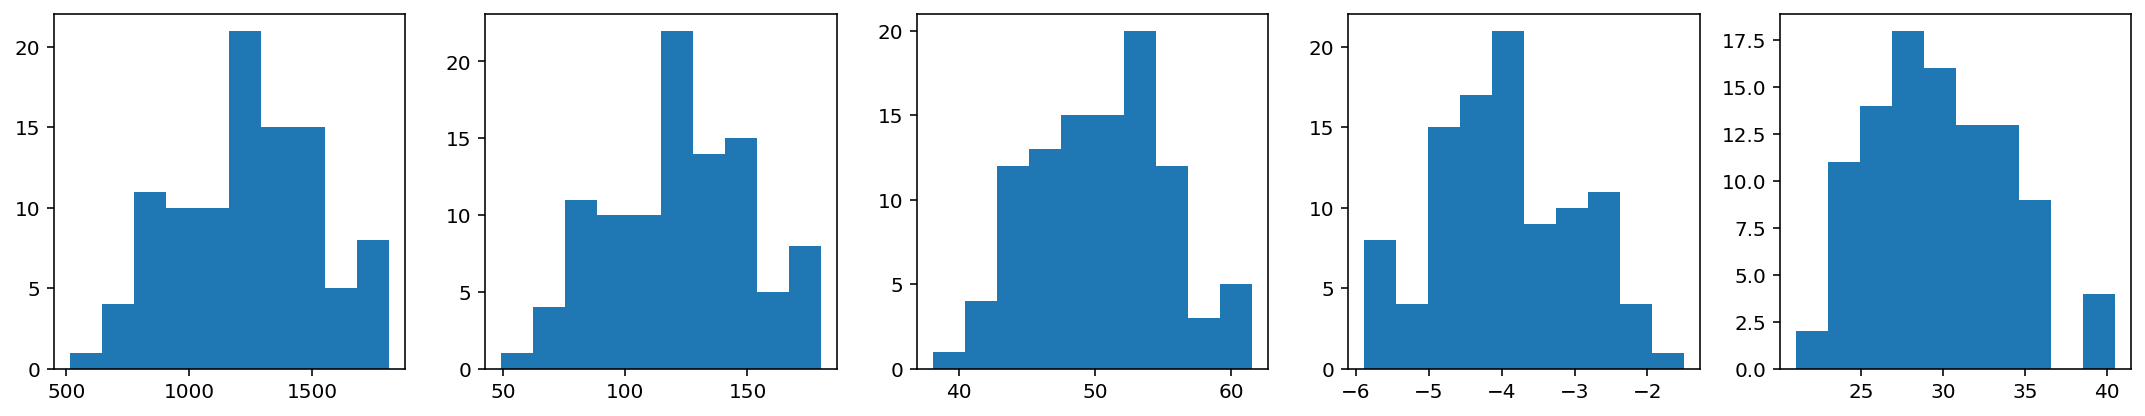

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(15, 3), ncols=5)

for var, ax in zip([aa, bb, cc, dd, ee], axes.flatten()):
    ax.hist(var)

plt.tight_layout()

Finally, plotting the joint distributions, we get:

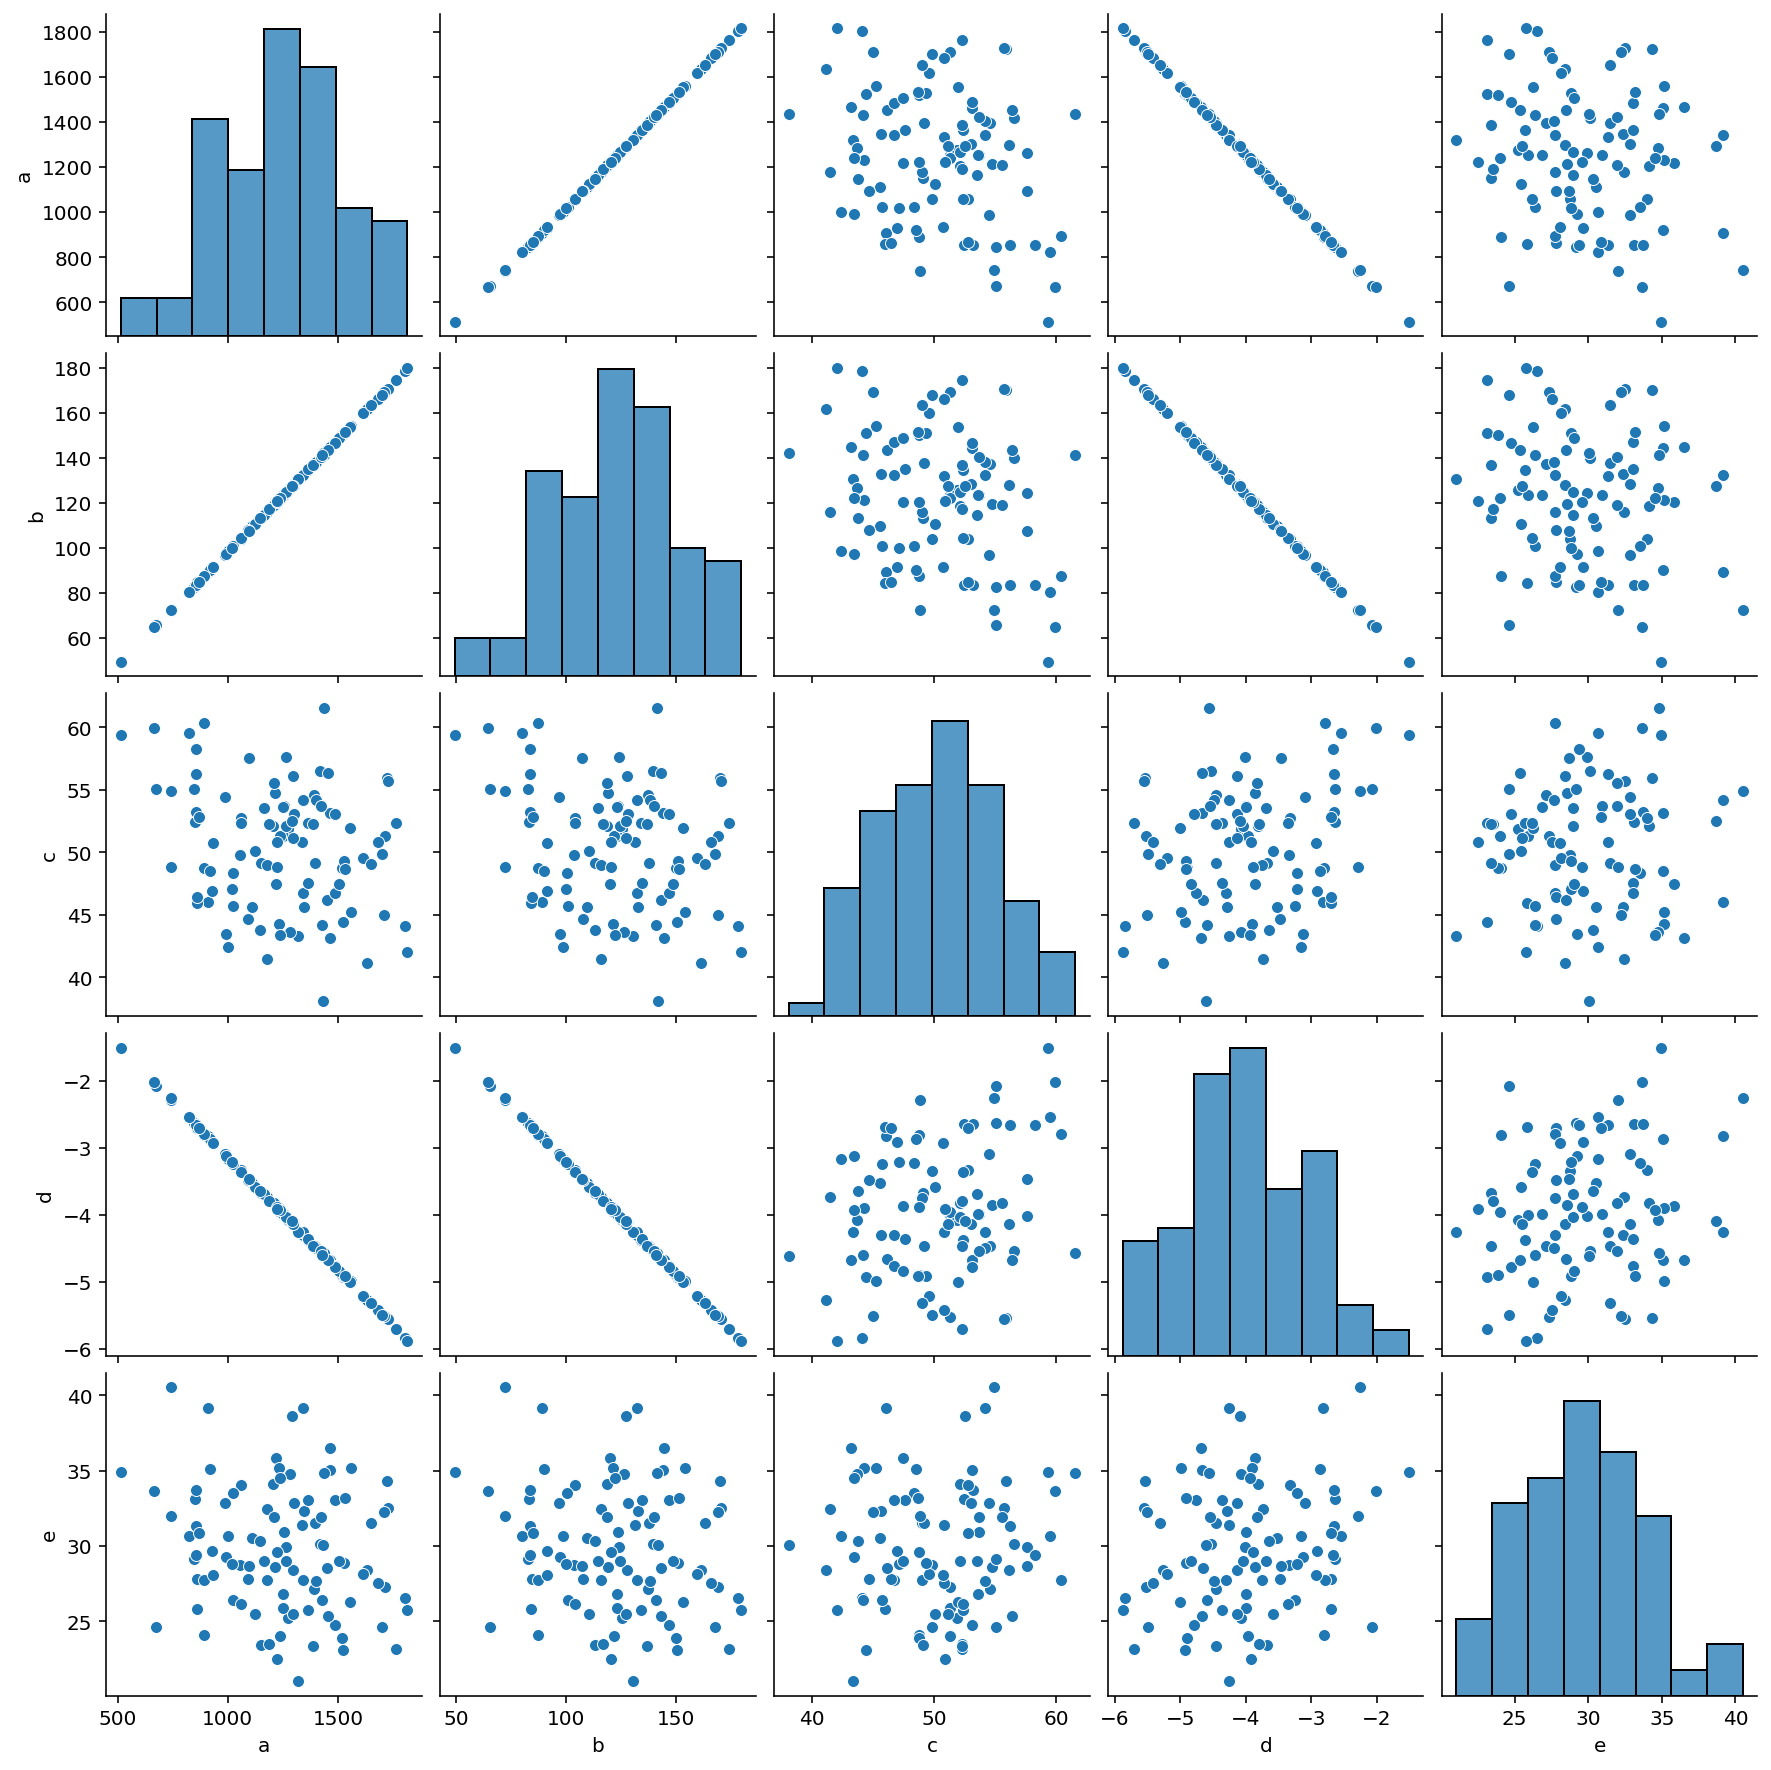

In [10]:
import seaborn as sns 

sns.pairplot(data)

Now that we have a feel for what kind of data we'll collect,
let's explore the three ways that the do-operator can be used.

### The do-operator: personalized counterfactuals

At an elementary level, the do-operator expresses mathematically the following quesiton,
“For a given sample, what if one of its variables took on a different value?” 
You can think of this as a "personalized" counterfactual for a given sample,
whether that sample is a patient, student, employee, citizen, or some other thing.

Some concrete examples of this in action are:

1. “For this given patient, what if the treatment given was the alternative treatment?”
2. “For this given student, what if they came from a wealthier household?”
3. “For this given tennis player, what if the court they played on were grass instead of clay?”



As you can see, one of the questions we’re asking when asking counterfactuals 
are in fact *personalized* for a given sample.

If we go back to the structural equations above, 
we could isolate a given observational data point $(a, b, c)$ and then ask the question, 
“What if in row $i$, $b$ took on a certain value $B$ instead of $b_i$?” 
This question, when asked, results in our probabilistic structure changing a bit:

1. We are now asking for $P(a_i | do(b_i=B), \beta, \gamma, c_i)$, where $i$ refers to the particular sample index.
2. Our counterfactual question presumes a known value of $b$, and hence no longer requires us to generate it from $(d, e)$. We can effectively cut $(d, e)$ out of the picture.

As long as we preserve uncertainty in the parameter values, 
we can obtain counterfactual uncertainty as well.
To illustrate how we do personalized counterfactuals in a Bayesian setting,
let's see how to do it with PyMC.

### Implementation with PyMC

We're going to start first by implementing the models.
There's no do-operations happening just yet,
we're just writing down the equations in PyMC first.

In [11]:
import pymc as pm

We first implement the set of equations.

In [12]:
with pm.Model() as model_a:
    a = pm.Data("a", data["a"])
    b = pm.Data("b", data["b"])
    c = pm.Data("c", data["c"])
    # Priors for model parameters
    beta = pm.Normal("beta", mu=10, sigma=3)
    gamma = pm.Normal("gamma", mu=0, sigma=10)
    sigma_a = pm.HalfCauchy("sigma_a", beta=1)
    pm.Normal("like", mu=beta * b + gamma * c, sigma=sigma_a, observed=a)


with pm.Model() as model_b:
    b = pm.Data("b", data["b"])
    d = pm.Data("d", data["d"])
    e = pm.Data("e", data["e"])
    # Priors for model parameters
    delta = pm.Normal("delta", mu=-15, sigma=15)

    epsilon = pm.Normal("epsilon", mu=0, sigma=1)
    sigma_b = pm.HalfCauchy("sigma_b", beta=1)
    pm.Normal("like", mu=delta * d + epsilon * e, sigma=sigma_b, observed=b)


Let's now plot the graphical model provided by PyMC.

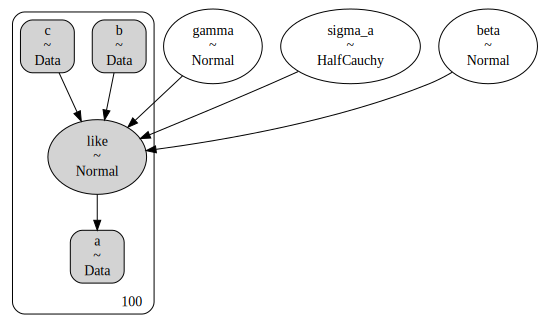

In [13]:
pm.model_to_graphviz(model_a)

In this model, we see that $a$, $b$, and $c$ are all observed data,
nested within the plate representing 1,000 data points.
$\beta$, $\gamma$, and $\sigma_a$ are the parameters of the model
that are invariant to any particular data point
and hence are located outside of the plate.
Those are our system-level parameters.
An analogous diagram exists for $b$'s model as well:

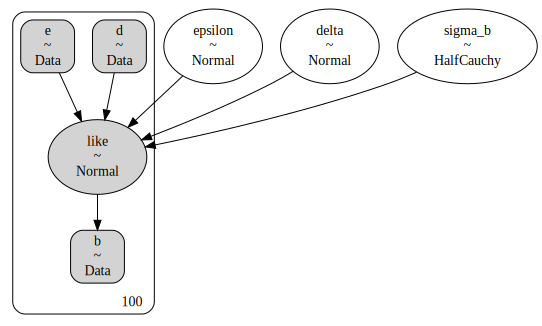

In [14]:
pm.model_to_graphviz(model_b)

### Parameter inference

We can now use PyMC's inference machinery, the Inference Buttom (tm),
to infer the values of the parameters above.

In [15]:
with model_a:
    idata_a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, gamma, sigma_a]
/opt/conda/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [16]:
with model_b:
    idata_b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta, epsilon, sigma_b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8938, but should be close to 0.8. Try to increase the number of tuning steps.


I will be skipping over a rigorous Bayesian workflow here
because it is not the point of the notebook.
Nonetheless, here is a set of plots for our posteriors;
you can check-them against the original Gaussian distributions above.

array([<AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'gamma'}>,
       <AxesSubplot:title={'center':'sigma_a'}>], dtype=object)

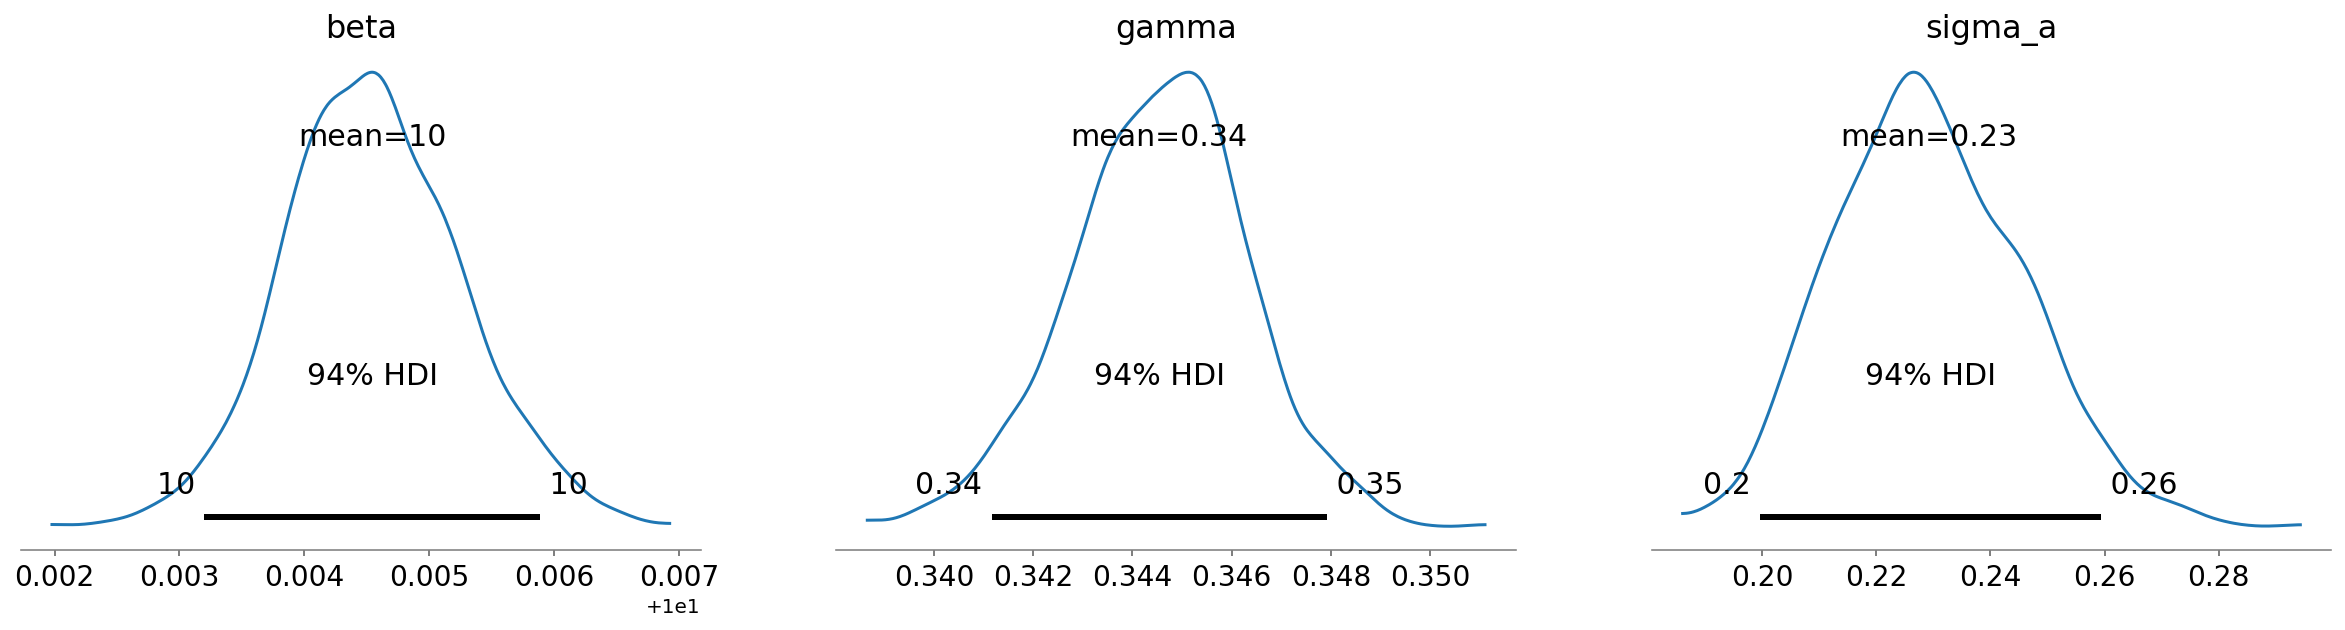

In [17]:
import arviz as az

az.plot_posterior(idata_a)

array([<AxesSubplot:title={'center':'delta'}>,
       <AxesSubplot:title={'center':'epsilon'}>,
       <AxesSubplot:title={'center':'sigma_b'}>], dtype=object)

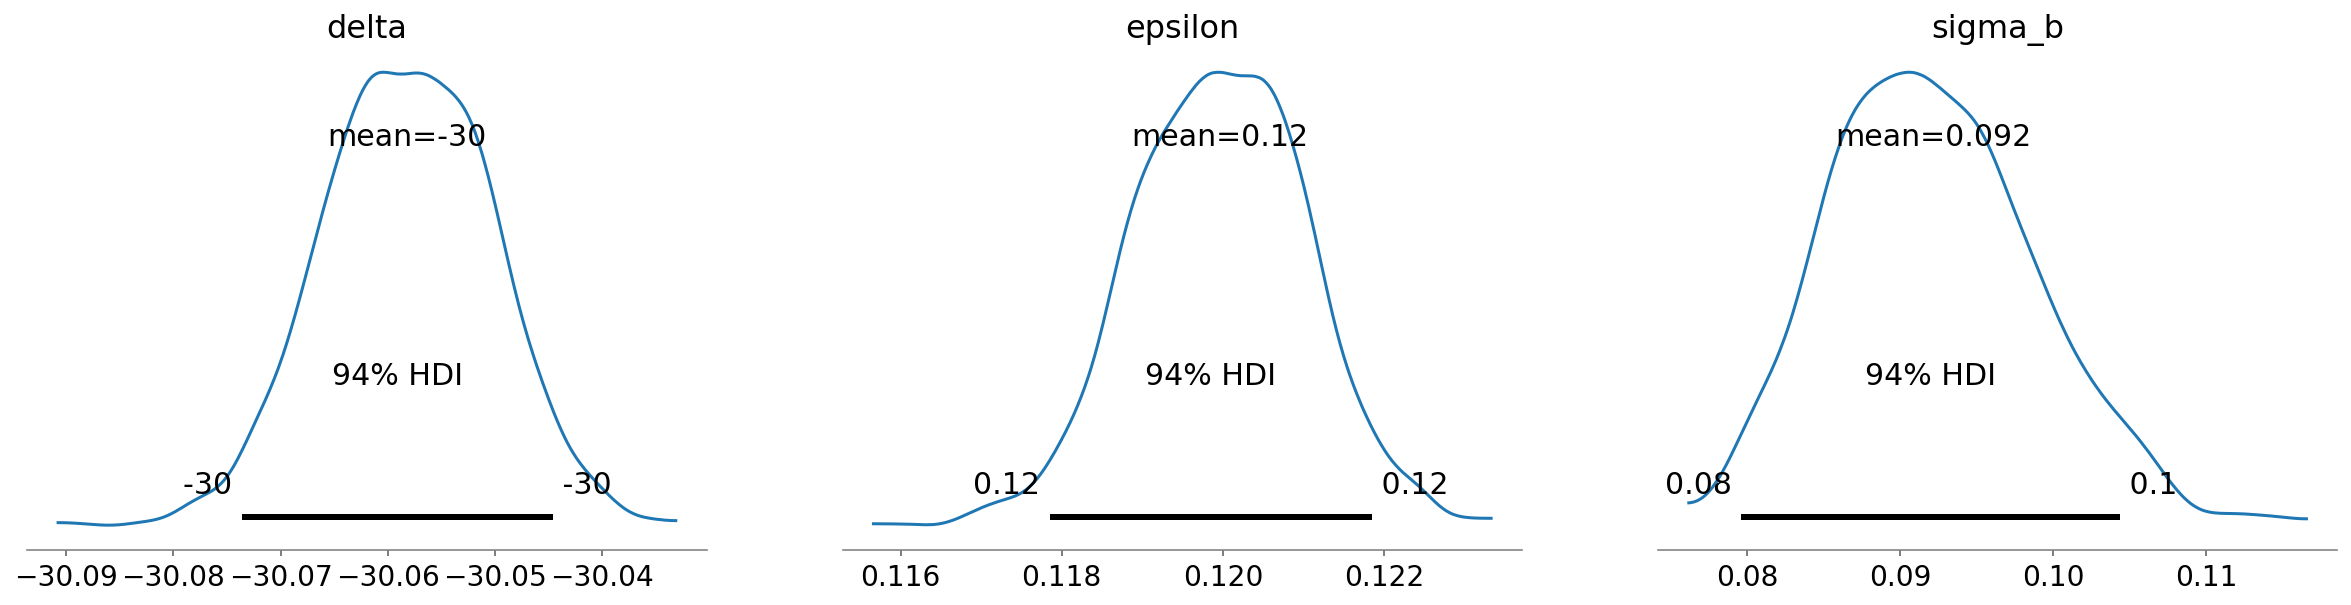

In [18]:
az.plot_posterior(idata_b)

In all of the cases, we're pretty close, though a bit off. 
As the goal here is to show a personalized counterfactual,
we're not going to worry too much about the parameter recovery accuracy.

### Personalized counterfactuals in PyMC

Personalized counterfactuals ask the question, 
"What would have happened for a particular sample,
i.e. one row in the dataset,
had one of its observed variables been a different value?"
In this case, we're going to take one of the observations 
and ask what would happen if we counterfactually set $b$ to a different value.

We'll start by isolating a sample of interest:

In [19]:
sample = data.sample(random_state=491)  # random state for reproducibility
sample["a"]

45    1230.47803
Name: a, dtype: float64

We then simulate what the posterior for that sample would look like
under the original case vs. the counterfactual case.
In the first code block below, we set our data variables to be a single sample
and then leverage the posterior predictive samples to simulate
what `a` would look like under the original data.
In the second code block, we set our data variables to be a single sample as well,
except that we have changed `b` to be a totally different value from what it was before.
This gives us our counterfactual scenario!

In [20]:
import numpy as np 

with model_a:
    # Simulate posterior predictive under original observed data.
    pm.set_data({"a": sample["a"], "b": sample["b"], "c": sample["c"]})
    ppc_or = pm.sample_posterior_predictive(idata_a)

    # Simulate posterior predictive under a counterfactual scenario.
    # ****This is the do-operator in action!****
    pm.set_data({"a": sample["a"], "b": sample["b"], "c": sample["c"] / 10})
    ppc_cf = pm.sample_posterior_predictive(idata_a)

Text(0.5, 1.0, 'Counterfactual')

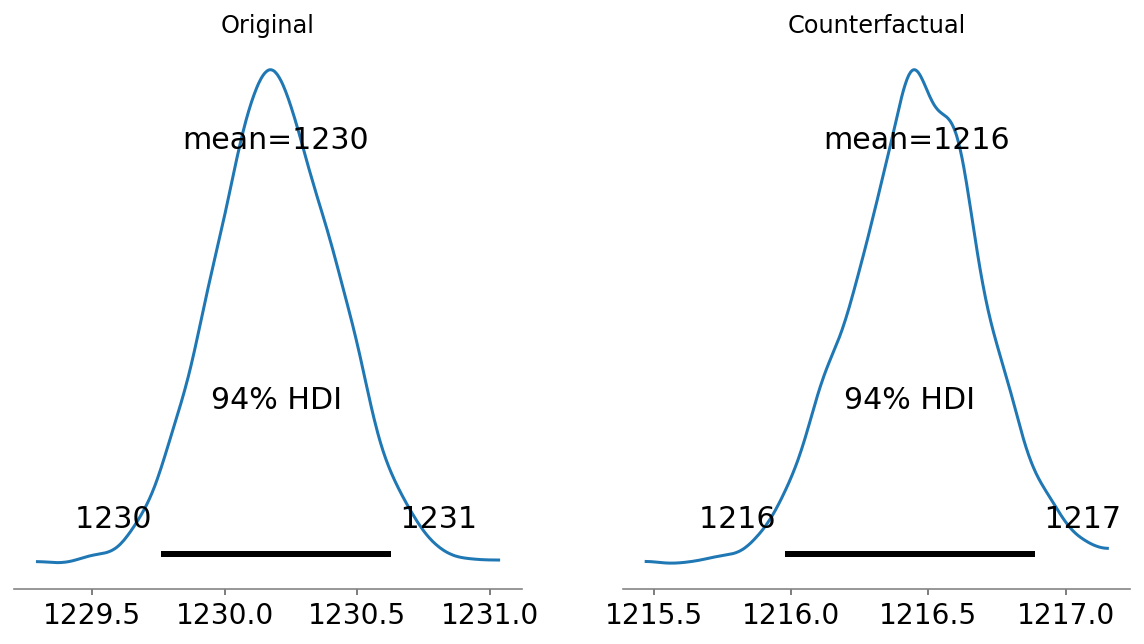

In [21]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
az.plot_posterior(ppc_or.posterior_predictive["like"], ax=axes[0])
axes[0].set_title("Original")

az.plot_posterior(ppc_cf.posterior_predictive["like"], ax=axes[1])
axes[1].set_title("Counterfactual")

What's really cool here is that we've done a personalized counterfactual
for that particular student.
In this case, we set the cost of the student's tuition fees to 1/10 the original, 
akin to sending them from a private school to a public school.
Under this particularly flawed model, we would expect their sum of grades to go down,
though not by a large magnitude.

The key trick to enabling this
was using `pm.Data()` containers for our data,
thus registering them with PyMC (and Aesara underneath)
as being hot-swappable entities with `pm.set_data()`.

Finally, because our _posterior_ distributions 
contain our probabilistic beliefs having seen the data,
or more colloquially, "fits of our parameters",
we sample from the _posterior predictive_ distribution
to identify what we would have gotten in a counterfactual situation.

## The do-operator: global counterfactuals

Let’s also think about another possible counterfactual question: 
What if the system parameters were different?

Recall here that “system parameters” refer to the linear coefficients. 
They aren’t properties of any observation (or sample), 
but are properties of the entire system as a whole, 
hence the moniker “global” counterfactuals.

To do global counterfactuals, 
we actually need to condition the coefficients’ values on a particular value, 
just like we did for data on the personalized counterfactual. 
For example, if we conditioned $\beta$  to be equal to 0,
in other words severing the relationship between $a$ and $b$, then:

1. We are now asking for $P(a|do(\beta=0), \gamma, b, c)$. (Notice the omission of subscript $i$, it’s intentional!)
2. Our counterfactual question presumes a known value of $\beta$, but not a presumed known value of any of $(b, c)$. (We aren't asking about any particular sample, after all!)


One way we can implement this do-operation is to reconstruct the model from our posteriors
while hard-coding the value of $\beta$ to 0.

Let's see how to make this happen.

Firstly, in order to take advantage of our fitted posteriors,
we will use a `from_posterior` function written implemented in the PyMC how-to guides.

In [22]:
from scipy import stats 

# Credit: https://docs.pymc.io/projects/examples/en/latest/pymc3_howto/updating_priors.html
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 1 * width], x, [x[-1] + 1 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)

Then, we'll need to rewrite the model a little bit,
this time hard-coding one of the variables to a particular value.

In [23]:
with pm.Model() as model_a_modified:
    a = pm.Data("a", data["a"])
    b = pm.Data("b", data["b"])
    c = pm.Data("c", data["c"])
    # Model parameters
    beta = 0  # ****This is the do-operator in action!****
    gamma = from_posterior("gamma", idata_a.posterior["gamma"].values.flatten())
    sigma_a = from_posterior("sigma_a", idata_a.posterior["sigma_a"].values.flatten())
    pm.Normal("like", mu=beta * b + gamma * c, sigma=sigma_a, observed=a)

Finally, since our posteriors have become priors in this new model,
we sample from the prior predictive distribution:

In [24]:
with model_a_modified:
    trace = pm.sample_prior_predictive()

/opt/conda/lib/python3.9/site-packages/pymc/distributions/continuous.py:3674: RuntimeWarning: divide by zero encountered in double_scalars
  np.where(np.abs(pdf[index]) <= 1e-8, np.zeros(index.shape), (p - cdf[index]) / pdf[index]),


Now, we're able to examine how our observations have changed
based on the intervention at the system.

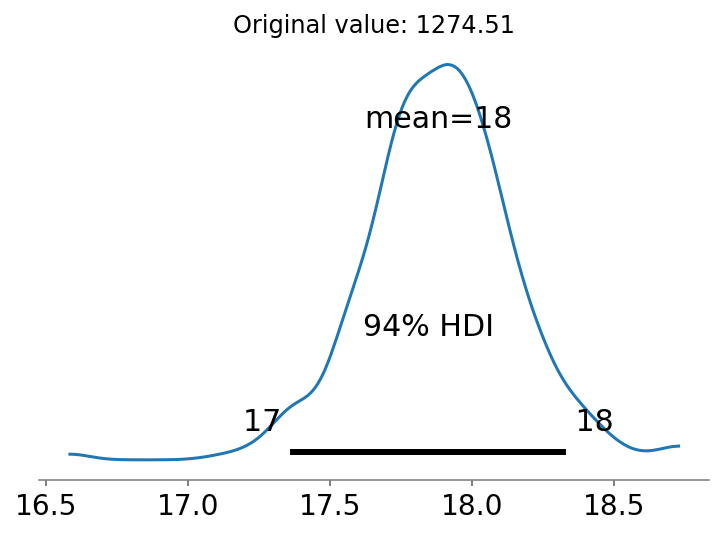

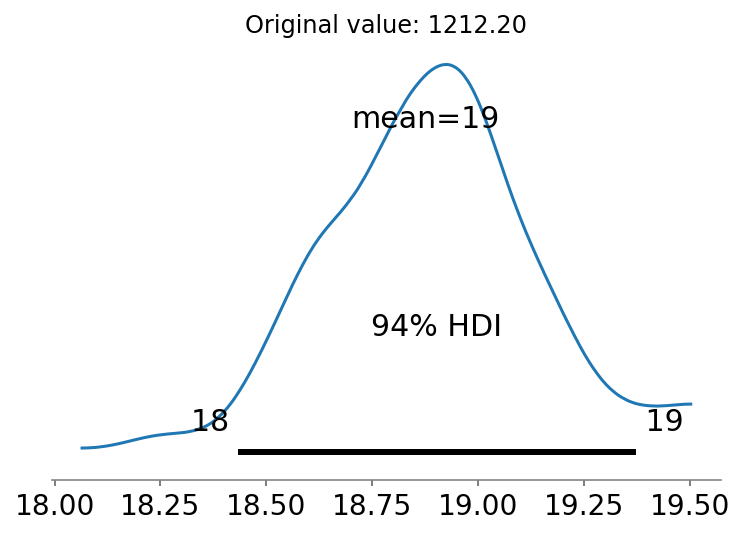

In [25]:
def plot_global_counterfactual(idx: int):
    az.plot_posterior(trace.prior_predictive["like"][0, :, idx])
    plt.gca().set_title(f"Original value: {data.loc[idx, 'a']:.2f}")


plot_global_counterfactual(2)
plot_global_counterfactual(3)


We can see here that by severing the connection between the IQ of a student and their grades,
each student's total sum of grades goes down to 1/20th of their original.
Those of us smarter than this author would probably have intuited this point without needing to code it up (by examining the magnitude of the slope coefficients),
but in the case of exotic functional forms with interaction terms (or a neural net structure),
the value of an explicit, global perturbation of an interpretable parameter is quite evident!

## The do-operator: combining global and personalized counterfactuals

If we’re thinking logically here, 
we’ll soon realize that it’s also possible 
to combine the two aforementioned counterfactuals together. 
We can ask the question, 
what is $P(a_i | do(\beta=0, b_i=B), \gamma, c_i)$? 
(Note again the presence of the index $i$!)

Algorithmically, this question essentially translates to:

1. picking out sample $i$, 
2. setting $b=B$, 
3. setting $beta=3.14$,
4. and evaluating what $a_i$ would look like under those two conditions.

For the sake of illustration, here it is in PyMC code:

In [26]:
with model_a_modified:
    pm.set_data({"a": sample["a"], "b": sample["b"], "c": sample["c"]})
    ppc_or = pm.sample_prior_predictive()

    # cf = "counterfactual"
    pm.set_data({"a": sample["a"], "b": sample["b"], "c": sample["c"] * 0.1})
    ppc_cf = pm.sample_prior_predictive()

/opt/conda/lib/python3.9/site-packages/pymc/distributions/continuous.py:3674: RuntimeWarning: divide by zero encountered in double_scalars
  np.where(np.abs(pdf[index]) <= 1e-8, np.zeros(index.shape), (p - cdf[index]) / pdf[index]),


Text(0.5, 1.0, 'Distribution of $a$ with $\\beta=0$ and $c = \\frac{c_i}{10}$')

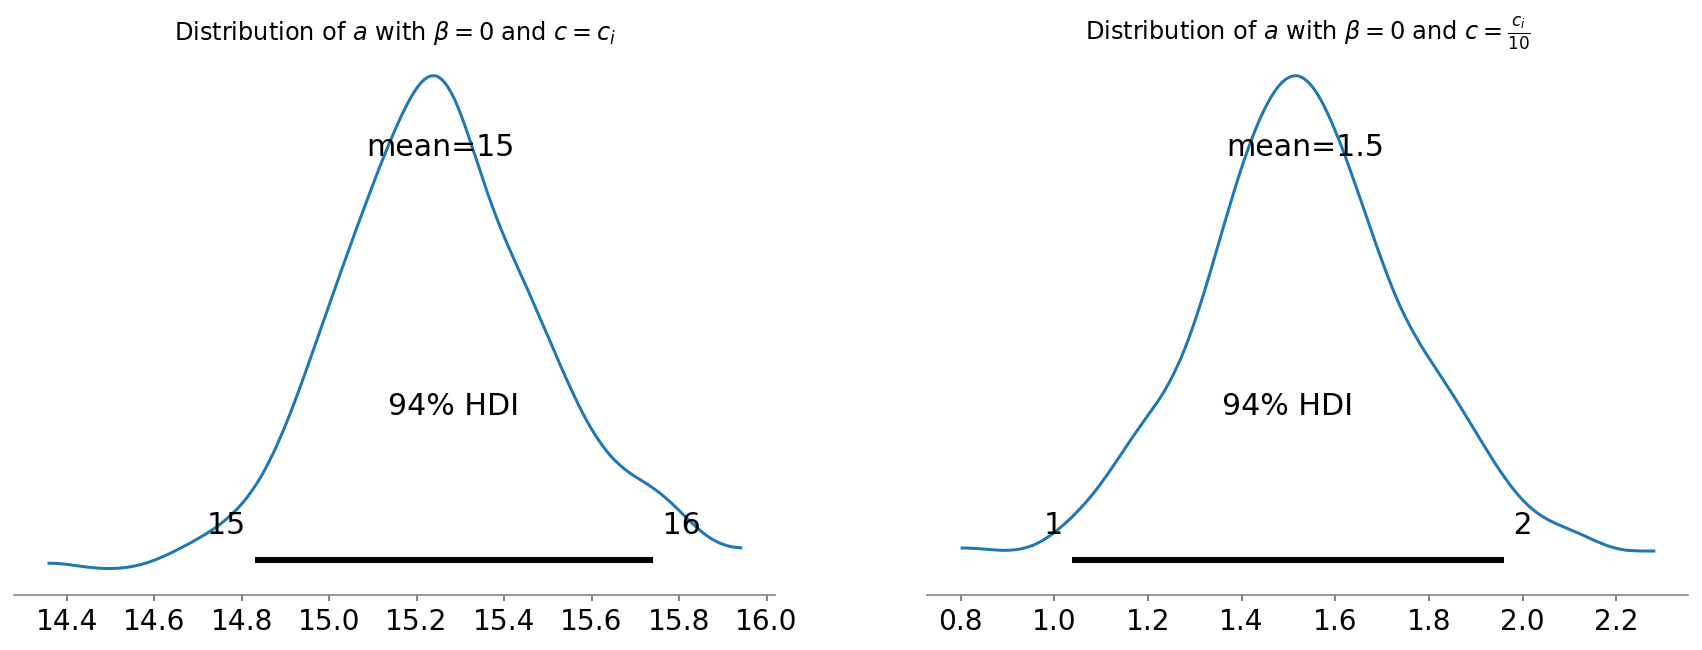

In [27]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
az.plot_posterior(ppc_or.prior_predictive["like"], ax=axes[0])
axes[0].set_title(r"Distribution of $a$ with $\beta=0$ and $c = c_i$")

az.plot_posterior(ppc_cf.prior_predictive["like"], ax=axes[1])
axes[1].set_title(r"Distribution of $a$ with $\beta=0$ and $c = \frac{c_i}{10}$")

## Framework

Having worked through this example, we've finally arrived at a framework for thinking through the connection between Bayesian models and causal models. 

To know which kind of counterfactual we need to employ, we have to be extremely clear on the exact question we’re trying to ask. Are we trying to ask:

1. A personalized question? (”What would have happened to this particular sample had its dependent variable been set to a particular value?”)
2. A systems-level question? (”What would happen to all of our observations if a system parameter was set to a particular value?”)
3. A hybrid question? (”What would have happened to this particular sample had its dependent variable been set to a particular value *and* the system parameter set to a particular value?”)

If we have our variables’ dependencies clearly and explicitly stated, then it becomes easy to ask the do-operator family of questions, which basically are asking, “What happens if we set something in the model to a particular value?”

## Summary

In this notebook, we have seen how to do causal inference on Bayesian models written in PyMC. 
We started with the contrast and comparison between causal and Bayesian inference.
Then, we went through the logical framework of asking counterfactuals on (1) a per-sample basis, (2) a system-wide basis, and (3) both together.

The value of the do-operator, and by extension causal methods,
is that they provide us the ability to ask these "what if" questions
in cases where conducting an experiment would be unethical, cost-prohibitive, or logistically challenging.
Combining it with Bayesian models gives us the ability to assess
what would have happened in a counterfactual world (causal)
while also calculating the full range of possibilities (Bayesian).
Blending the two together is nothing more than a matter of logic!